In [81]:
import keras
keras.__version__

'2.4.3'

# Third homework 'introduction to deep learning'
## Part 1 - Section 6.3: Advanced usage of recurrent neural networks

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural 
networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will 
demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors 
installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 
24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered 
when working with timeseries.

We will cover the following techniques:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).
* *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and 
mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence 
data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is 
perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a 
few days worth of data points) and predicts the air temperature 24 hours in the future.

Downloading the data in Google Colab:

In [82]:
!wget -cq https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip 
!unzip -qq jena_climate_2009_2016.csv.zip 
fname = 'jena_climate_2009_2016.csv'

Let's take a look at the data:

In [83]:
import os

#data_dir = 'jena_climate_2009_2016.csv'
#fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let's convert all of these 420,551 lines of data into a Numpy array:

In [84]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [85]:
float_data.shape
float_data[1,]

array([ 9.9657e+02, -8.4100e+00,  2.6501e+02, -9.2800e+00,  9.3400e+01,
        3.2300e+00,  3.0200e+00,  2.1000e-01,  1.8900e+00,  3.0300e+00,
        1.3098e+03,  7.2000e-01,  1.5000e+00,  1.3610e+02])

For instance, here is the plot of temperature (in degrees Celsius) over time:

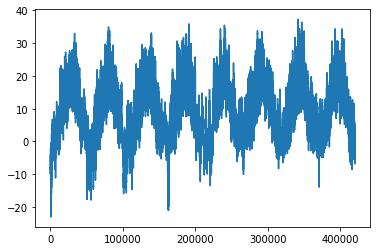

In [86]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

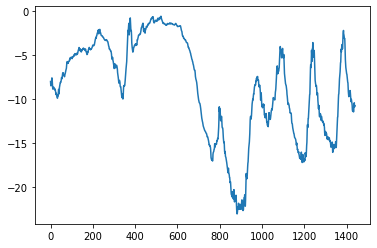

In [87]:
plt.plot(range(1440), temp[:1440])
plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [88]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [89]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [90]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 

Here's our evaluation loop:

In [91]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 13s 22ms/step - loss: 2.2976 - val_loss: 1.0176
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.7124 - val_loss: 0.3803
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.3469 - val_loss: 0.3296
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2834 - val_loss: 0.3087
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2648 - val_loss: 0.3146
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2505 - val_loss: 0.2998
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2443 - val_loss: 0.3384
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2374 - val_loss: 0.3358
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2321 - val_loss: 0.3177
Epoch 10/20
500/500 [==============================] - 10s 21ms/step - loss: 0.226

Let's display the loss curves for validation and training:

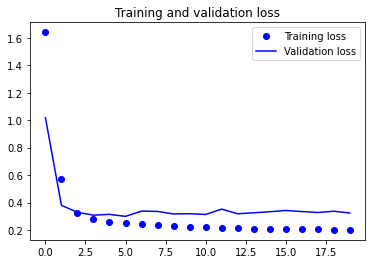

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
500/500 [==============================] - 21s 30ms/step - loss: 0.3183 - val_loss: 0.2683
Epoch 2/5
500/500 [==============================] - 15s 29ms/step - loss: 0.2861 - val_loss: 0.2659
Epoch 3/5
500/500 [==============================] - 15s 29ms/step - loss: 0.2809 - val_loss: 0.2657
Epoch 4/5
500/500 [==============================] - 15s 29ms/step - loss: 0.2765 - val_loss: 0.2639
Epoch 5/5
500/500 [==============================] - 15s 30ms/step - loss: 0.2719 - val_loss: 0.2623


From this experiment onwards, the recurrent networks have not been trained for the full number of epochs in the book since according to the ETA for running one epoch, this would too much time.

Let look at our results:

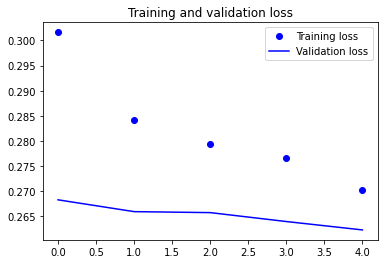

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 409s 815ms/step - loss: 0.3541 - val_loss: 0.2771
Epoch 2/5
500/500 [==============================] - 406s 812ms/step - loss: 0.3072 - val_loss: 0.2728
Epoch 3/5
500/500 [==============================] - 405s 810ms/step - loss: 0.3018 - val_loss: 0.2765
Epoch 4/5
500/500 [==============================] - 406s 812ms/step - loss: 0.2959 - val_loss: 0.2716
Epoch 5/5
500/500 [==============================] - 403s 805ms/step - loss: 0.2907 - val_loss: 0.2667


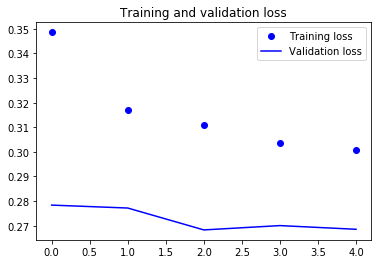

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 4 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 336s 671ms/step - loss: 0.3364 - val_loss: 0.2756
Epoch 2/5
500/500 [==============================] - 335s 671ms/step - loss: 0.3128 - val_loss: 0.2773
Epoch 3/5
500/500 [==============================] - 336s 672ms/step - loss: 0.3067 - val_loss: 0.2680
Epoch 4/5
500/500 [==============================] - 335s 671ms/step - loss: 0.3034 - val_loss: 0.2667
Epoch 5/5
500/500 [==============================] - 334s 668ms/step - loss: 0.3016 - val_loss: 0.2685


Let's take a look at our results:

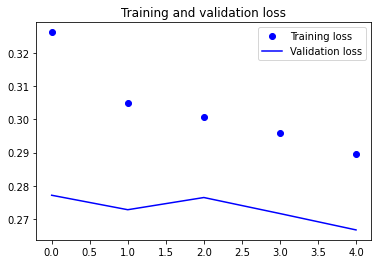

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers do improve our results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss 
improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this 
point.

### Part 1: Assignment 1

Now as noted in the beginning of section 6.3.7, absence of too bad overfitting likely implies that the model is under capacity.  Also that we can increase the network capacity typically by increasing the number of units in layers or adding more layers. In this assignment, we are going to try 3 different arctecture choices each with different number of units of the recurrent layer(s) in the “stacked GRU model”.

**Comment on the arctecture choices..**

**Arctecture 1**


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 833s 2s/step - loss: 0.3353 - val_loss: 0.2810
Epoch 2/5
500/500 [==============================] - 831s 2s/step - loss: 0.3005 - val_loss: 0.2743
Epoch 3/5
500/500 [==============================] - 833s 2s/step - loss: 0.2932 - val_loss: 0.2787
Epoch 4/5
500/500 [==============================] - 831s 2s/step - loss: 0.2816 - val_loss: 0.2651
Epoch 5/5
500/500 [==============================] - 818s 2s/step - loss: 0.2747 - val_loss: 0.2717


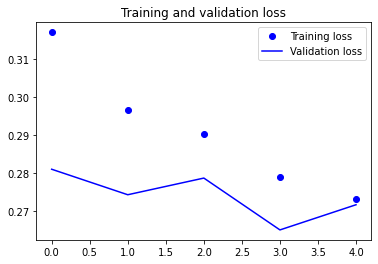

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Arctecture 2**


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 847s 2s/step - loss: 0.3406 - val_loss: 0.2799
Epoch 2/5
500/500 [==============================] - 857s 2s/step - loss: 0.3024 - val_loss: 0.2769
Epoch 3/5
500/500 [==============================] - 841s 2s/step - loss: 0.2921 - val_loss: 0.2675
Epoch 4/5
500/500 [==============================] - 831s 2s/step - loss: 0.2806 - val_loss: 0.2669
Epoch 5/5
500/500 [==============================] - 828s 2s/step - loss: 0.2714 - val_loss: 0.2729


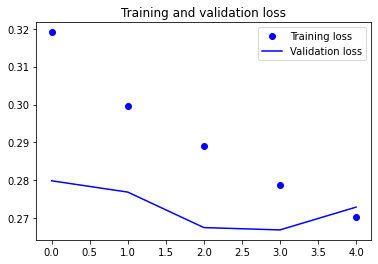

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Arctecture 3**


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 841s 2s/step - loss: 0.3354 - val_loss: 0.2770
Epoch 2/5
500/500 [==============================] - 842s 2s/step - loss: 0.2981 - val_loss: 0.2777
Epoch 3/5
500/500 [==============================] - 852s 2s/step - loss: 0.2872 - val_loss: 0.2788
Epoch 4/5
500/500 [==============================] - 848s 2s/step - loss: 0.2740 - val_loss: 0.2706
Epoch 5/5
500/500 [==============================] - 843s 2s/step - loss: 0.2656 - val_loss: 0.2760


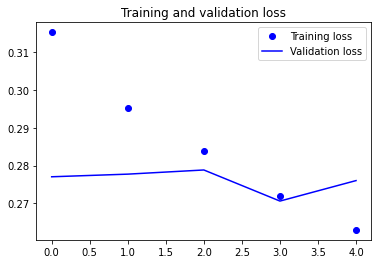

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Part 1: Assignment 2

In this assignent, we shall try to improve the GRU stacked model by stacking different numbers of dense layers. We are still going to try 3 different arctecture choices.

**Comment on the arctecture choices..**

**Arctecture 1** (Stacking another but small dense layer)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)


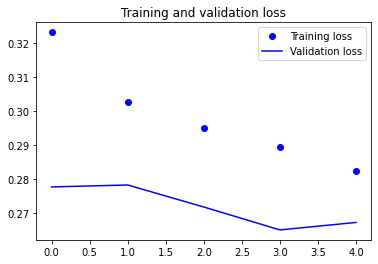

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Arctecture 2** (Making the stacked dense layer larger)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 909s 2s/step - loss: 0.3490 - val_loss: 0.2898
Epoch 2/5
500/500 [==============================] - 921s 2s/step - loss: 0.3044 - val_loss: 0.2800
Epoch 3/5
500/500 [==============================] - 912s 2s/step - loss: 0.2972 - val_loss: 0.2817
Epoch 4/5
500/500 [==============================] - 884s 2s/step - loss: 0.2884 - val_loss: 0.2710
Epoch 5/5
500/500 [==============================] - 883s 2s/step - loss: 0.2819 - val_loss: 0.2738


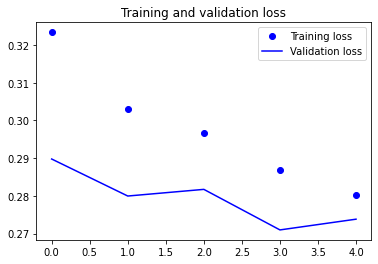

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Arctecture 3** (Stacking two large dense layers)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 877s 2s/step - loss: 0.3426 - val_loss: 0.2781
Epoch 2/5
500/500 [==============================] - 860s 2s/step - loss: 0.3046 - val_loss: 0.2770
Epoch 3/5
500/500 [==============================] - 852s 2s/step - loss: 0.2955 - val_loss: 0.2746
Epoch 4/5
500/500 [==============================] - 848s 2s/step - loss: 0.2845 - val_loss: 0.2759
Epoch 5/5
500/500 [==============================] - 854s 2s/step - loss: 0.2733 - val_loss: 0.2792


This model collapses from the first Epoch, putting more stacks of layers may might crash the model.

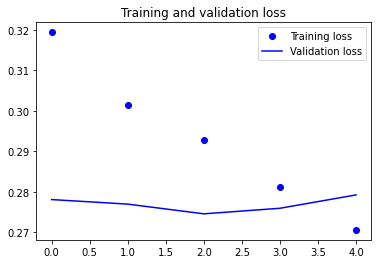

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Part 1: Assignment 3 - Testing the best performing model
The model in archtecture 1 of the first assignment of part 1 remains better with a validation loss of around 0.265 but not so performant on the test dataset.

In [ ]:
test_acc = model.evaluate(test_gen, steps = 1000)

In [ ]:
test_acc

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s - loss: 0.4781 - val_loss: 0.4797
Epoch 2/20
500/500 [==============================] - 171s - loss: 0.4529 - val_loss: 0.4679
Epoch 3/20
500/500 [==============================] - 170s - loss: 0.4071 - val_loss: 0.4536
Epoch 4/20
500/500 [==============================] - 171s - loss: 0.3670 - val_loss: 0.4398
Epoch 5/20
500/500 [==============================] - 170s - loss: 0.3343 - val_loss: 0.4320
Epoch 6/20
500/500 [==============================] - 170s - loss: 0.3191 - val_loss: 0.4388
Epoch 7/20
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.4186
Epoch 8/20
500/500 [==============================] - 170s - loss: 0.2938 - val_loss: 0.4014
Epoch 9/20
500/500 [==============================] - 170s - loss: 0.2824 - val_loss: 0.4077
Epoch 10/20
500/500 [==============================] - 170s - loss: 0.2724 - val_loss: 0.4090
Epoch 11/20
500/500 [==============================] - 170s - loss: 0

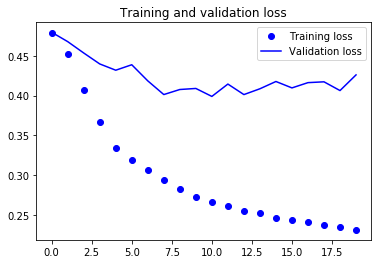

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 111s - loss: 0.4965 - acc: 0.7648 - val_loss: 0.3593 - val_acc: 0.8570
Epoch 2/10
20000/20000 [==============================] - 107s - loss: 0.3105 - acc: 0.8810 - val_loss: 0.3329 - val_acc: 0.8648
Epoch 3/10
20000/20000 [==============================] - 105s - loss: 0.2566 - acc: 0.9057 - val_loss: 0.3863 - val_acc: 0.8770
Epoch 4/10
20000/20000 [==============================] - 106s - loss: 0.2231 - acc: 0.9195 - val_loss: 0.3471 - val_acc: 0.8556
Epoch 5/10
20000/20000 [==============================] - 105s - loss: 0.1912 - acc: 0.9314 - val_loss: 0.3346 - val_acc: 0.8694
Epoch 6/10
20000/20000 [==============================] - 105s - loss: 0.1721 - acc: 0.9379 - val_loss: 0.3621 - val_acc: 0.8520
Epoch 7/10
20000/20000 [==============================] - 105s - loss: 0.1613 - acc: 0.9427 - val_loss: 0.3438 - val_acc: 0.8694
Epoch 8/10
20000/20000 [========================


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 214s - loss: 0.5994 - acc: 0.6865 - val_loss: 0.4722 - val_acc: 0.8090
Epoch 2/10
20000/20000 [==============================] - 213s - loss: 0.3673 - acc: 0.8543 - val_loss: 0.3769 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 213s - loss: 0.2743 - acc: 0.8972 - val_loss: 0.3196 - val_acc: 0.8688
Epoch 4/10
20000/20000 [==============================] - 211s - loss: 0.2310 - acc: 0.9150 - val_loss: 0.2972 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 211s - loss: 0.2009 - acc: 0.9261 - val_loss: 0.4461 - val_acc: 0.8514
Epoch 6/10
20000/20000 [==============================] - 210s - loss: 0.1912 - acc: 0.9339 - val_loss: 0.3636 - val_acc: 0.8640
Epoch 7/10
20000/20000 [==============================] - 209s - loss: 0.1670 - acc: 0.9423 - val_loss: 0.3476 - val_acc: 0.8580
Epoch 8/10
20000/20000 [========================

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 325s - loss: 0.3029 - val_loss: 0.2660
Epoch 2/40
500/500 [==============================] - 324s - loss: 0.2751 - val_loss: 0.2660
Epoch 3/40
500/500 [==============================] - 326s - loss: 0.2668 - val_loss: 0.2628
Epoch 4/40
500/500 [==============================] - 326s - loss: 0.2594 - val_loss: 0.2615
Epoch 5/40
500/500 [==============================] - 324s - loss: 0.2532 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 324s - loss: 0.2442 - val_loss: 0.2674
Epoch 7/40
500/500 [==============================] - 324s - loss: 0.2405 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 324s - loss: 0.2343 - val_loss: 0.2782
Epoch 9/40
500/500 [==============================] - 324s - loss: 0.2293 - val_loss: 0.2778
Epoch 10/40
500/500 [==============================] - 324s - loss: 0.2233 - val_loss: 0.2813
Epoch 11/40
500/500 [==============================] - 324s - loss: 0


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* As you first learned in Chapter 4, when approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.

## Part 2: Keras advanced API






In [1]:
from keras import layers
from keras import models

In [2]:
# Load CIFAR10 data
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 4s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
# Reshaping the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [5]:
# One hot encoding for the class element of each sample.
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
#  Validation set. We set apart 10000 samples in our training data
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]
# So..
train_data = (partial_X_train, partial_y_train) 
# and..
validation_data=(X_val, y_val)
# Also..
test_data = (X_test, y_test)

print(partial_X_train.shape)
print(X_val.shape)
print(X_test.shape)
print('')
print(partial_y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)

(40000, 10)
(10000, 10)
(10000, 10)


Archtecture 1: Let's start with the larger convnet from part 1 of homework 2 which was out best model with an accuracy of 69.92%

In [7]:
# Our covolution network
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


# The densely-connected classifier network
model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Model summary to see how the dimensions of the feature maps change with 
# every successive layer:
model.summary()

# The compilation step
from keras import optimizers
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Lastly we shall call the fit method of our model for the network to start 
# iterating on the training data in mini-batches of 64 samples, 5 times over 
# all the training data (5 epochs).
history = model.fit(partial_X_train, partial_y_train, epochs=10, batch_size=64, 
validation_data=validation_data)

# Evaluation of the model
scores = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.2f%%" % (test_scores[1]*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

Since we are to apply some visualization tools like Keras callbacks so as to monitor models during training and several other best practices, these aren’t possible when using only the Sequential model class in
Keras. We shall thus switch to a far more general and flexible Keras functional API. 
Since the model above does moderately well, we will start with it's fuctional equivalent from which we shall consider other archtectures. Let's start by importing necessary packages:



In [13]:
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
from sklearn import metrics
from keras.models import Sequential, Model
from keras import layers
from keras import Input

**Archtecture 2**: API functional quivalent of the best sequential model from homework 2

In [43]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model2 = Model(input_tensor, output_tensor)
model2.summary()
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.fit(partial_X_train, partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model2.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 2, 2, 128)         0  

Quite a good performance, as good as the previous case. But let's try to improve it by trying the following model archtectures.

**Archtecture 3**: Increasing on the number of dense layers and units therein. This 
network will probably have 
 have statistical power on cifar-10 that is sufficient to solve the 
problem well. 

In [44]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model3 = Model(input_tensor, output_tensor)
model3.summary()
model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.fit(partial_X_train, partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model3.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 2, 2, 128)         0  

We observe a slight decrease in performance from the previous archtecture. So we so far stick to archtecture 2 which implies doing away with the extra dense layer.

**Archtecture 4**: Let's next try to increase on the number units in the one dense layer of archtecture 2, because if we need to classify data into a large number of categories, we should avoid
creating information bottlenecks in your network due to intermediate layers that are too small.

In [45]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model4 = Model(input_tensor, output_tensor)
model4.summary()
model4.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.fit(partial_X_train, partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model4.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 2, 2, 128)         0  

A slight improvement. We now take on archtecture 4 as our preferred model so far.

**Arctecture 5**: What about a larger number of filters in convolution layers for our model to combined better low level features to many complex shapes. This enables a better distinguishing between classes

In [47]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(65, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model5 = Model(input_tensor, output_tensor)
model5.summary()
model5.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model5.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 30, 30, 65)        1820      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 15, 15, 65)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 13, 13, 128)       75008     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 2, 2, 256)         0  

We still notice an improvement. So archtecture 5 is our best model so far.

Archtecture 6: Now in this best model so far, let's try to reduce on the batch size

In [48]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(65, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model6 = Model(input_tensor, output_tensor)
model6.summary()
model6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model6.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 30, 30, 65)        1820      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 15, 15, 65)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 13, 13, 128)       75008     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 2, 2, 256)         0  

This implies that we shall stick to a batch size to 64 in model5.

Archtecture 7: Increasing on the learning rate from the default. (from 0.002)

In [49]:
from keras.optimizers import RMSprop
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(64, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model7 = Model(input_tensor, output_tensor)
model7.summary()
model7.compile(optimizer=RMSprop(lr = 0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model7.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))
# Evaluation of the model
scores = model7.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 2, 2, 256)         0  

### Conclusion
A slight increase in the model performance. So we conclude to archtecture 5 as our best model so far, with a validation accuracy of 73.32%. Let's try to evaluate it on the test dataset.

In [50]:
test_scores = model5.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.2f%%" % (test_scores[1]*100))

Test accuracy: 72.85%


The test accuracy is almost as good as the validation accuracy. This can be attributed to the not having experienced the issue of overfitting on the validation data thereby generalisable validation accuracy. Let's save this model as 'cifar10_API_1.h5'.

In [51]:
model5.save('cifar10_API_1.h5')


## Keras callbacks
When you’re training a model, there are many things you can’t predict from the start. For instance you can’t tell how many epochs will be needed to get to an optimal validation loss. A much better way to handle this is to stop training when you measure that the validation loss in no longer improving. This can be achieved using a Keras callback. 

Here, we shall explore two ways we can use callbacks, that is, Early stopping and Dynamically adjusting the value of certain parameters during training—Such as the
learning rate of the optimizer.

### Early stopping
This is basically for interrupting training when the validation loss is no longer improving and continually saving the best model obtained during training by using it in combination with ModelCheckpoint.

In [59]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(64, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model8 = Model(input_tensor, output_tensor)
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='acc',patience=1,),keras.callbacks.ModelCheckpoint
            (filepath='cifar10_API_2.h5',monitor='val_loss',save_best_only=True,)]
model8.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model8.fit(partial_X_train,partial_y_train,epochs=10,batch_size=64,callbacks=callbacks_list,
                        validation_data=(X_val, y_val))
# Evaluation of the model
scores = model8.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 1.9032 - acc: 0.3011 - val_loss: 1.2813 - val_acc: 0.5404
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2237 - acc: 0.5701 - val_loss: 0.9901 - val_acc: 0.6520
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.9600 - acc: 0.6629 - val_loss: 1.1164 - val_acc: 0.6337
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.7776 - acc: 0.7321 - val_loss: 0.8468 - val_acc: 0.7159
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6410 - acc: 0.7788 - val_loss: 1.0333 - val_acc: 0.6872
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5060 - acc: 0.8250 - val_loss: 0.8504 - val_acc: 0.7281
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4034 - acc: 0.8616 - val_loss: 0.9222 - val_acc: 0.7210
Epoch 8/10
625/625 [==============================] - 4s 6ms/step - loss: 0.

### The ReduceLROnPlateau callback
You can use this callback to reduce the learning rate when the validation loss has
stopped improving. Reducing or increasing the learning rate in case of a loss plateau is
is an effective strategy to get out of local minima during training.

In [60]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(64, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model9 = Model(input_tensor, output_tensor)
callbacks_list = [
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1, patience=10,)]
model9.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model9.fit(partial_X_train, partial_y_train,epochs=10,batch_size=64,callbacks=callbacks_list,
                      validation_data=(X_val, y_val))

# Evaluation of the model
scores = model9.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 1.8865 - acc: 0.3082 - val_loss: 1.2427 - val_acc: 0.5513
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2026 - acc: 0.5757 - val_loss: 1.0126 - val_acc: 0.6415
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.9528 - acc: 0.6673 - val_loss: 0.8546 - val_acc: 0.7054
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.7602 - acc: 0.7356 - val_loss: 0.8090 - val_acc: 0.7216
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6210 - acc: 0.7841 - val_loss: 0.8438 - val_acc: 0.7145
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4997 - acc: 0.8255 - val_loss: 0.9240 - val_acc: 0.7040
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3926 - acc: 0.8633 - val_loss: 0.9221 - val_acc: 0.7307
Epoch 8/10
625/625 [==============================] - 4s 6ms/step - loss: 0.

## Advanced architecture patterns
We are going to use three important design pattern in detail in the previous section: Batch normalization, depthwise separable convolution and Model ensembling. These patterns are especially relevant when you’re building high-performing deep convnets, but they’re commonly found
in many other types of architectures as well.

In [61]:
input_tensor = Input(shape=(32,32,3))
x = layers.Conv2D(64, (3, 3), activation='relu')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model10 = Model(input_tensor, output_tensor)
model10.summary()

model10.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model10.fit(partial_X_train, partial_y_train,epochs=10,batch_size=64,
                      validation_data=(X_val, y_val))

# Evaluation of the model
scores = model10.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 128)       512       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 6, 6, 128)         0  

In [65]:
input_tensor = Input(shape=(32,32,3))
x = layers.SeparableConv2D(64, (3, 3), activation='relu')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.SeparableConv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.SeparableConv2D(256, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model11 = Model(input_tensor, output_tensor)
model11.summary()

model11.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model11.fit(partial_X_train, partial_y_train,epochs=10,batch_size=64,
                      validation_data=(X_val, y_val))

# Evaluation of the model
scores = model11.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 30, 30, 64)        283       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 15, 15, 64)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 13, 13, 128)       8896      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 4, 4, 256)         34176     
_________________________________________________________________
flatten_39 (Flatten)         (None, 4096)              0  

## Model ensembling
This is a powerful technique for obtaining the best possible results on a task is model ensembling. Ensembling relies on the assumption that different good models trained independently are likely to be good for different reasons: each model looks at slightly different
aspects of the data to make its predictions, getting part of the “truth” but not all of it. Let's apply this as follows;

In [67]:
# Five different models to use to compute initial predictions.
preds_a = model5.predict(X_test)
preds_b = model8.predict(X_test)
preds_c = model9.predict(X_test)
preds_d = model10.predict(X_test)
preds_e = model11.predict(X_test)


In [69]:
# Going from the prediction probabilities for each class  to the 
# predicted class using numpy.argmax.
import numpy as np
preds_a_2 = np.argmax(preds_a, axis =1)
preds_b_2 = np.argmax(preds_b, axis =1)
preds_c_2 = np.argmax(preds_c, axis =1)
preds_d_2 = np.argmax(preds_d, axis =1)
preds_e_2 = np.argmax(preds_e, axis =1)


In [70]:
y_preds_a_2 = to_categorical(preds_a_2)
y_preds_b_2 = to_categorical(preds_b_2)
y_preds_c_2 = to_categorical(preds_c_2)
y_preds_d_2 = to_categorical(preds_d_2)
y_preds_e_2 = to_categorical(preds_e_2)


In [73]:
# Precision scores
pred_a_score = metrics.precision_score(y_test, y_preds_a_2, average='macro')
pred_b_score = metrics.precision_score(y_test, y_preds_b_2, average='macro')
pred_c_score = metrics.precision_score(y_test, y_preds_c_2, average='macro')
pred_d_score = metrics.precision_score(y_test, y_preds_d_2, average='macro')
pred_e_score = metrics.precision_score(y_test, y_preds_e_2, average='macro')
pred_total = pred_a_score + pred_b_score + pred_c_score + pred_d_score + pred_e_score 
print(pred_a_score)
print(pred_b_score)
print(pred_c_score)
print(pred_d_score)
print(pred_e_score)


0.733326391429419
0.7241653682169947
0.7267787197077016
0.712982256749798
0.6478985580883533


In [75]:
final_preds = (pred_a_score/pred_total) * preds_a + (pred_b_score/pred_total) * preds_b + (pred_c_score/pred_total) * preds_c +(pred_d_score/pred_total) * preds_d +(pred_e_score/pred_total) * preds_e 


In [77]:
final_preds_2 = np.argmax(final_preds, axis =1)
y_final_preds_2 = to_categorical(final_preds_2)
metrics.precision_score(y_test, y_final_preds_2, average='macro')

0.7837499028106949

The model outperforms all our previous models.